In [37]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [40]:
from jupyterthemes import jtplot
from tensorflow import set_random_seed
set_random_seed(42)
jtplot.style()
# Constantes
SEED = 42
m = 64
tau = 1
delta = 2

In [45]:
from Funciones import GenersConjuntos
from Funciones import plot_history

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from keras import regularizers
from tensorflow import keras
import numpy as np
import pandas as pd
np.random.seed(7)

Using TensorFlow backend.


In [29]:
#TS = pd.read_csv('time_series_60min_singleindex.csv')
df=pd.read_csv('household_power_consumption.txt', delimiter=';')

C:\Users\MARM\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
# Date and time indexing
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])
df['date_time']=pd.to_datetime(df['date_time']) 

df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]

df.sort_values('date_time', inplace=True, ascending=True)

df = df.reset_index(drop=True)

df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


In [33]:
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')

In [34]:
df.to_csv('modificacion.csv', header=True, index=False)

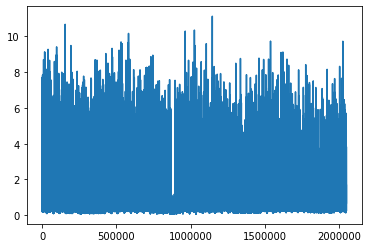

In [38]:
serie = np.array(dataset)
plt.plot(serie)
plt.show()

In [41]:
def ModMLP(show=True): # Modelo de la red neuronal a utilizar
    inputs = keras.Input(shape=(m))
    x = layers.Dense(64, activation='sigmoid')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(delta, activation='linear')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='forecasting')
    
    if(show):
        model.summary()
    
    return model

In [43]:

mean = serie.mean()
std = serie.std()
serie.shape

(2049280,)

In [46]:
X_train, X_val, X_test, y_train, y_val, y_test=  GenersConjuntos(serie, 0.3, 0.2)

In [47]:
X_val.shape

(286890, 64)

In [48]:
model = ModMLP()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "forecasting"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 46,018
Trainable params: 46,018
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(loss="mean_squared_error", optimizer="sgd", metrics=['mae', 'mse','accuracy'])

In [51]:
callback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    batch_size=64,
                    callbacks=[callback],
                    epochs=20,
                    validation_data=(X_val, y_val))

test_scores = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])
print('Test mse:', test_scores[2])
print('Test acc:', test_scores[3])

Train on 1147560 samples, validate on 286890 samples
Epoch 1/20
1147560/1147560 [==============================] - 45s 39us/sample - loss: 0.0890 - mean_absolute_error: 0.1218 - mean_squared_error: 0.0890 - acc: 0.4229 - val_loss: 0.0902 - val_mean_absolute_error: 0.1177 - val_mean_squared_error: 0.0902 - val_acc: 0.6212
Epoch 2/20
1147560/1147560 [==============================] - 48s 41us/sample - loss: 0.0887 - mean_absolute_error: 0.1213 - mean_squared_error: 0.0887 - acc: 0.4221 - val_loss: 0.0897 - val_mean_absolute_error: 0.1171 - val_mean_squared_error: 0.0897 - val_acc: 0.4011
Epoch 3/20
1147560/1147560 [==============================] - 49s 43us/sample - loss: 0.0883 - mean_absolute_error: 0.1211 - mean_squared_error: 0.0883 - acc: 0.4205 - val_loss: 0.0882 - val_mean_absolute_error: 0.1200 - val_mean_squared_error: 0.0882 - val_acc: 0.4765
Epoch 4/20
1147560/1147560 [==============================] - 50s 43us/sample - loss: 0.0881 - mean_absolute_error: 0.1208 - mean_squared

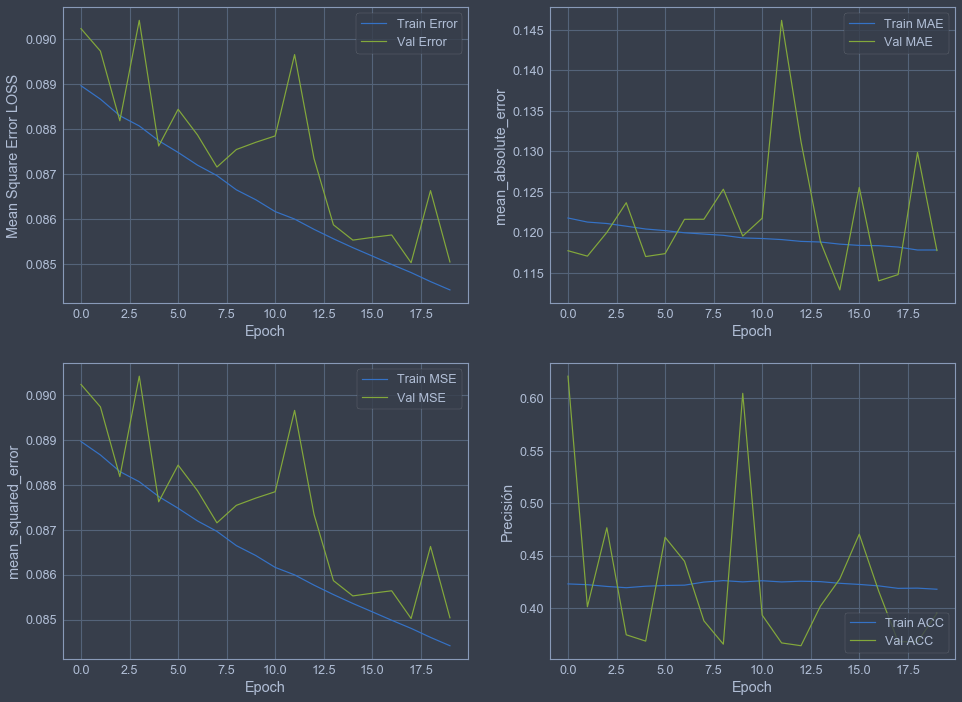

In [52]:
plot_history(history)

In [53]:
y_predic= model.predict(X_test)

In [54]:
r = y_test - y_predic
ab = abs(r)

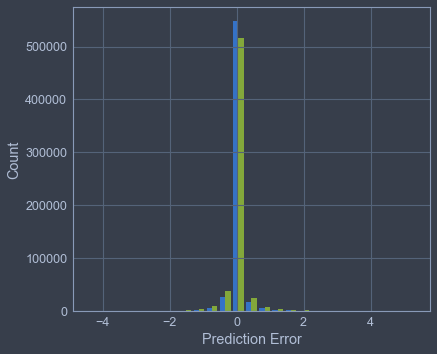

In [55]:
plt.hist(r, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

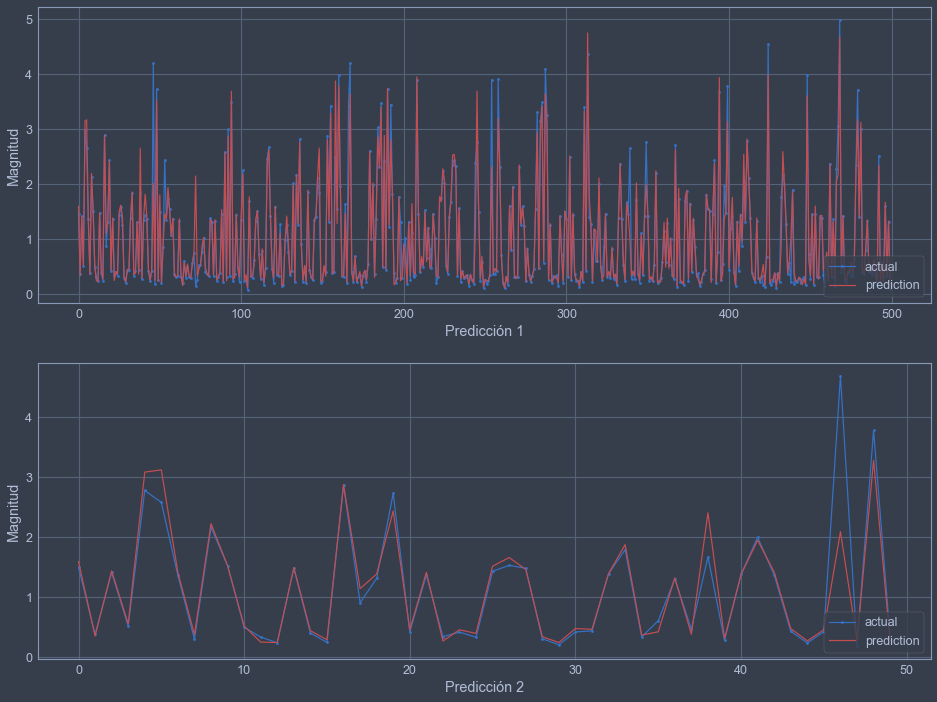

In [59]:
Y_inv = y_test*std + mean
Y_pred_inv = y_predic*std + mean

plt.figure(figsize=(16, 12))
plt.subplot(211)
plt.xlabel('Predicción 1')
plt.ylabel('Magnitud')
plt.plot(Y_inv[0:500, 0],marker='.', label="actual")
plt.plot(Y_pred_inv[0:500, 0], 'r', label="prediction")
plt.legend(loc="lower right")

plt.subplot(212)
plt.xlabel('Predicción 2')
plt.ylabel('Magnitud')
plt.plot(Y_inv[0:50, 1],marker='.', label="actual")
plt.plot(Y_pred_inv[0:50, 1], 'r', label="prediction")
plt.legend(loc="lower right")
plt.show()